В таблице regs.csv находится количество регистраций пользователей в еЛаме по месяцам по июль 2022
Требуется написать Python-скрипт, который прогнозирует количество регистраций в августе 2022.

Ответ предоставить в виде кода скрипта в Jupiter Notebook или Google Colab и таблицы, содержащей исходный временной ряд и прогнозное значение на 2022-08.


In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.dummy import DummyClassifier
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
!pip install pmdarima
from pmdarima.arima import auto_arima
!pip install lightgbm
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression


In [4]:
regs = pd.read_csv('regs.csv', parse_dates=['period'], index_col='period')

In [5]:
regs


,users
period,
2020-06-01,8623
2020-07-01,7904
2020-08-01,8237
2020-09-01,9267
2020-10-01,8868
2020-11-01,8058
2020-12-01,7422
2021-01-01,8233
2021-02-01,8571


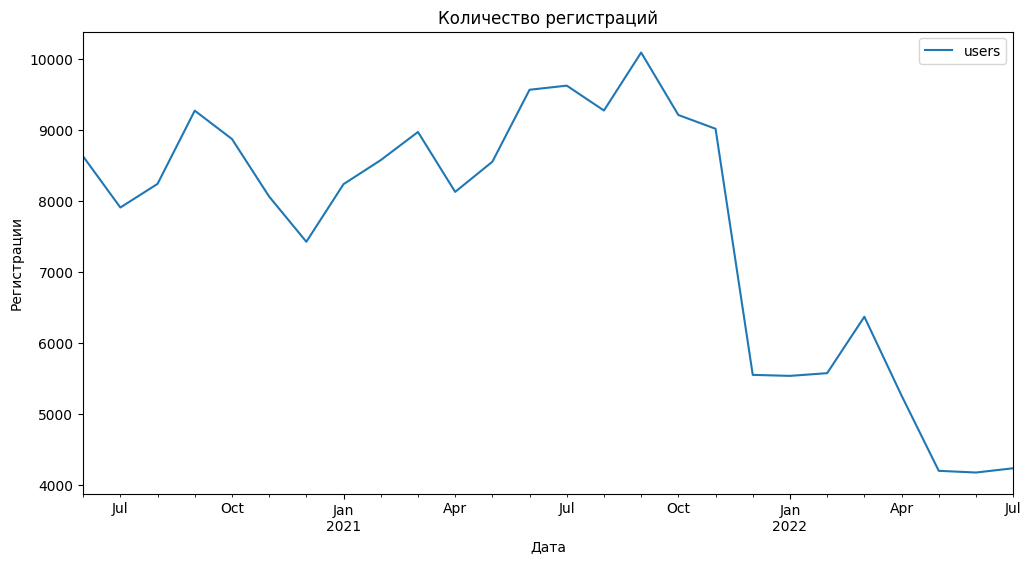

In [6]:
# Визуализация временного ряда
regs.plot(figsize=(12, 6))
plt.xlabel('Дата')
plt.ylabel('Регистрации')
plt.title('Количество регистраций')
plt.show()

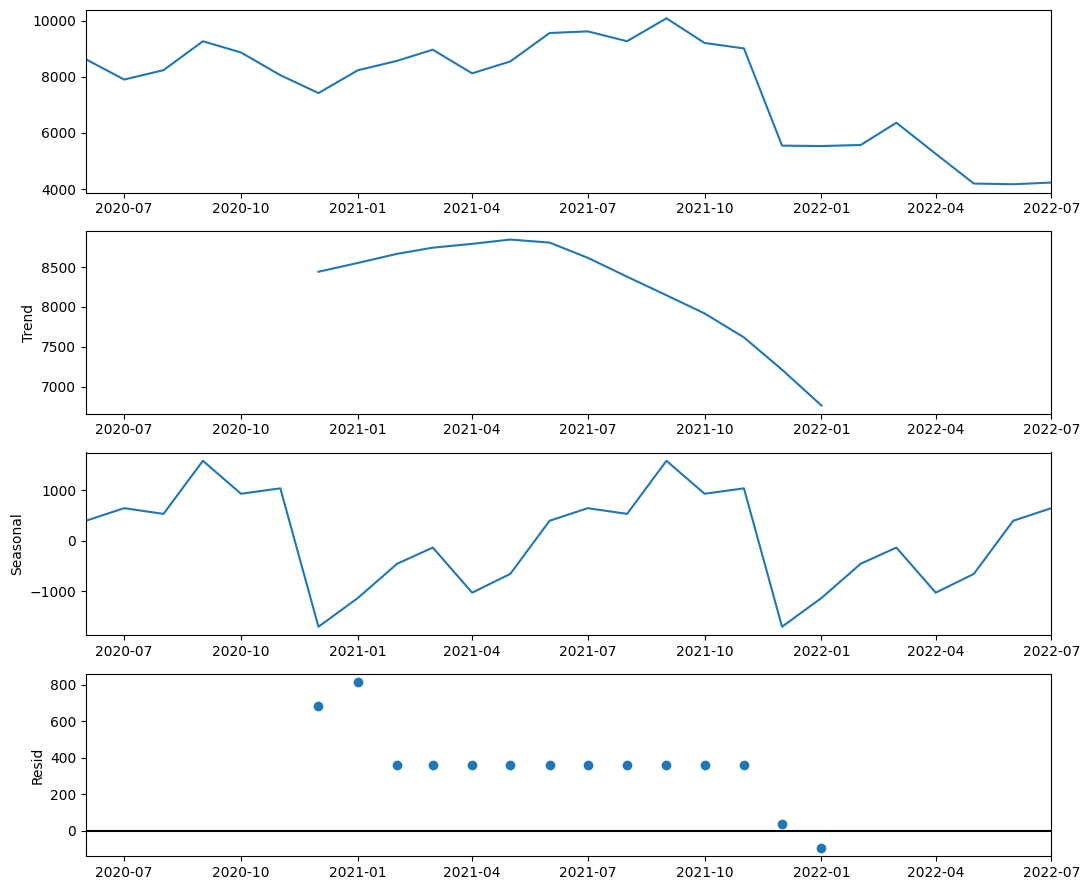

In [67]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decompose = seasonal_decompose(regs)
decompose.plot()

plt.show()

Проверим временной ряд на стационарность. Используем пороговое значение, равное 0,05 (5%)

In [8]:
adf_test = adfuller(regs['users'])

# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.8617883036448093


P-value - явно выше 0.05, можем сделать вывод, что ряд нестационарен.



## Разделим данные на test и train

In [53]:
# Разделим данные на обучающую и тестовую выборки
train = regs["2020-06-01":"2022-01-01"]  # Обучающий набор (исключая последний месяц)
test = regs["2022-01-01":]  # Тестовый набор (включая последний месяц)

## Создадим наивный прогноз

In [54]:
# Разделение данных на обучающий и тестовый наборы
train_naive = regs[:-1]  # Обучающий набор (исключая последний месяц)

# Получение последнего известного значения из обучающей выборки
last_value = train['users'].iloc[-1]

# Создание наивного прогноза
naive_forecast = pd.Series([last_value] * len(test), index=test.index)

# Оценка производительности наивного прогноза
mse = mean_squared_error(test['users'], naive_forecast)
mae = mean_absolute_error(test['users'], naive_forecast)

print('Naive Forecast:')
print(naive_forecast)
print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)

Naive Forecast:
period
2022-01-01    5535
2022-02-01    5535
2022-03-01    5535
2022-04-01    5535
2022-05-01    5535
2022-06-01    5535
2022-07-01    5535
dtype: int64
Mean Squared Error (MSE): 870699.0
Mean Absolute Error (MAE): 734.7142857142857


## Linear Regression

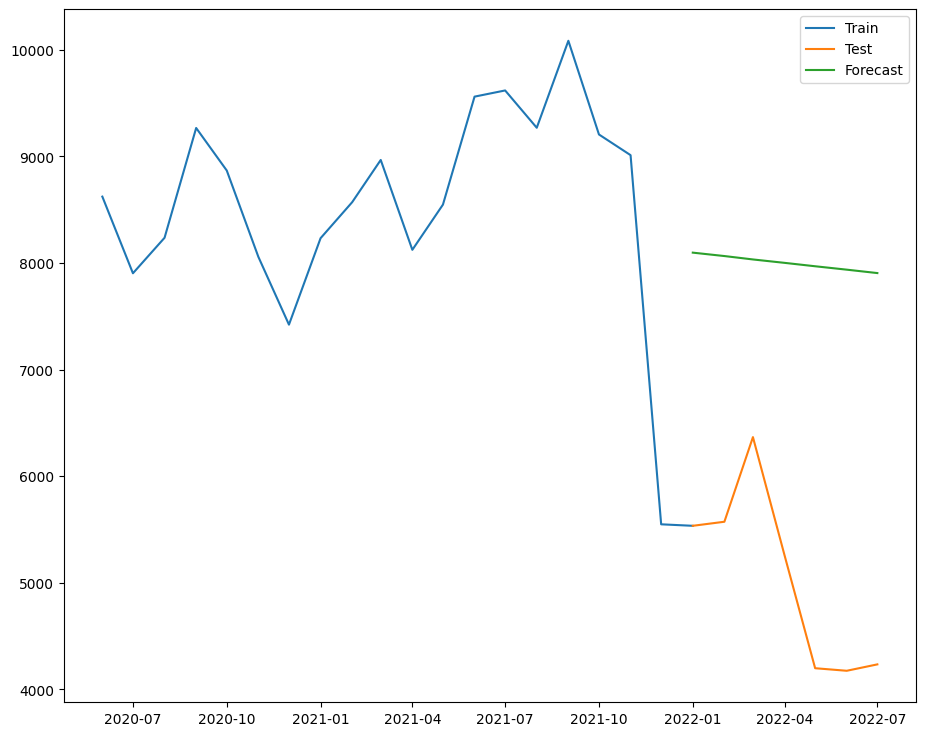

Mean Squared Error (MSE): 9276783.45873481
Mean Absolute Error (MAE): 2952.8345864661655


In [55]:
# Создадим объект линейной регрессии
model = LinearRegression()

# Обучим модель на обучающей выборке
X_train = np.arange(len(train)).reshape(-1, 1)
y_train = train['users']
model.fit(X_train, y_train)

# Получим прогноз на тестовой выборке
X_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
forecast = model.predict(X_test)

# Визуализируем исходные данные и прогноз
plt.plot(train['users'], label='Train')
plt.plot(test['users'], label='Test')
plt.plot(test.index, forecast, label='Forecast')  # Добавляем прогнозные значения на график
plt.legend()

# Покажем график
plt.show()

# Рассчитаем метрики ошибки
mse = mean_squared_error(test['users'], forecast)
mae = mean_absolute_error(test['users'], forecast)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)






## LightGBM

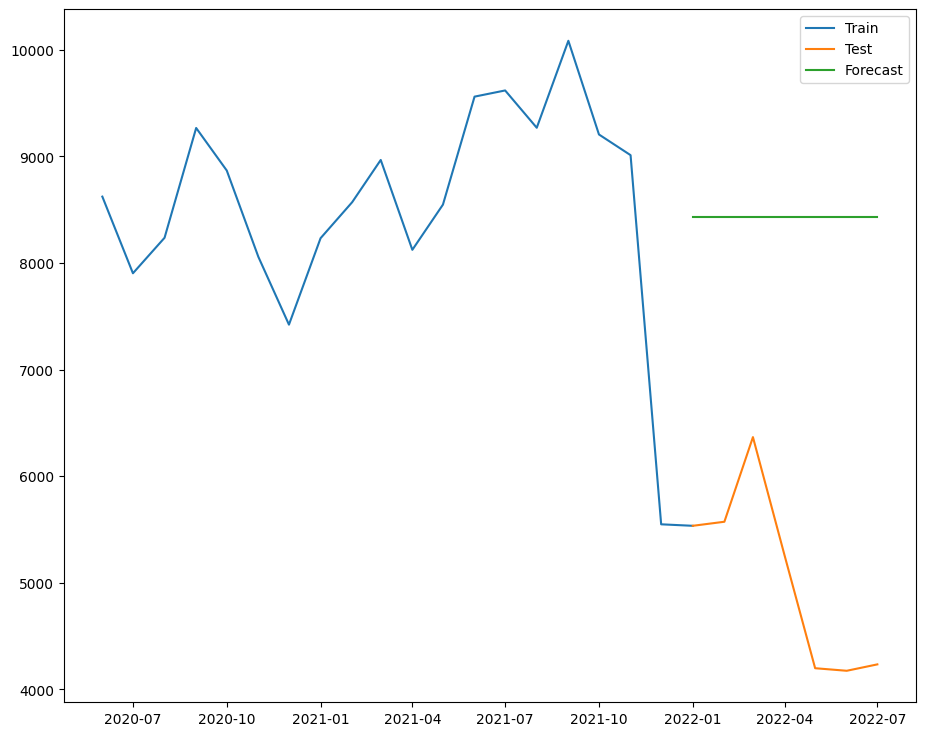

In [56]:
# Создаем модель LightGBM
model = LGBMRegressor()

# Обучаем модель на обучающей выборке
model.fit(train.index.values.reshape(-1, 1), train['users'])

# Получите прогноз на основе обученной модели
forecast = model.predict(test.index.values.reshape(-1, 1), n_periods=len(test)+1)

# Визуализируйте исходные данные и прогноз
plt.plot(train['users'], label='Train')
plt.plot(test['users'], label='Test')
plt.plot(test.index, forecast, label='Forecast')  # Добавляем прогнозные значения на график
plt.legend()

# Покажем график
plt.show()




In [57]:
# Рассчитаем метрики
mse = mean_squared_error(test['users'], forecast)
mae = mean_absolute_error(test['users'], forecast)
#r2 = r2_score(test['users'], forecast)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
#print("R-squared (R2):", r2)

Mean Squared Error (MSE): 12086110.181428568
Mean Absolute Error (MAE): 3384.0428571428565


In [58]:
params = {
    "seasonal": False,
    "start_p": 0,
    "start_q": 0,
    "max_p": 5,
    "max_q": 5,
    "m": 12,
}

In [59]:
modeling = auto_arima(
    train,
    seasonal = params["seasonal"],
    start_p=params["start_p"],
    start_q=params["start_q"],
    max_p=params["max_p"],
    max_q=params["max_q"],
    stepwise=True,
)

modeling.fit(train)

ARIMA(order=(0, 0, 2), scoring_args={}, suppress_warnings=True)

In [64]:
# Определение модели ARIMA с полученными параметрами
model = ARIMA(train, order=(0, 0, 2))
model_fit = model.fit()

# Прогнозирование на тестовом наборе данных
predictions = model_fit.forecast(steps=len(test))

# Вывод прогнозных значений
print(predictions)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2022-02-01    6130.610853
2022-03-01    7701.770341
2022-04-01    8421.952997
2022-05-01    8421.952997
2022-06-01    8421.952997
2022-07-01    8421.952997
2022-08-01    8421.952997
Freq: MS, Name: predicted_mean, dtype: float64


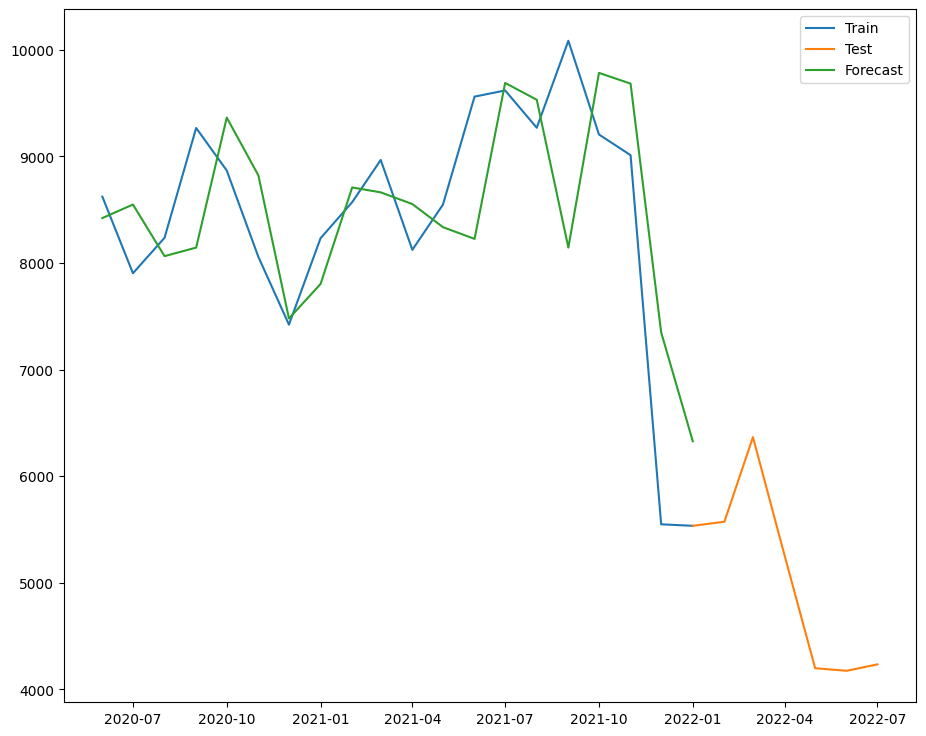

In [65]:
forecast = model_fit.predict(n_periods=len(test))

plt.plot(train['users'], label='Train')
plt.plot(test['users'], label='Test')
plt.plot(forecast, label='Forecast')
plt.legend()

plt.show()

In [66]:
# Расчет MSE и MAE
true = regs['users']  # Фактические значения
pred = forecast  # Прогнозные значения
mse = np.mean((true - pred)**2)
mae = np.mean(np.abs(true - pred))

print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)

Mean Squared Error (MSE): 668972.3932179548
Mean Absolute Error (MAE): 621.0917403621847
